## NYC 뉴욕 택시 데이터 EDA (Time)
- 1월에 대한 데이터만 추출하여 진행

In [1]:
import chart_studio.plotly as py
import cufflinks as cf
import warnings
from utils import info
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
cf.go_offline()

### 시간에 따른 datetime별 Trip의 수요

In [3]:
# 1월 픽업데이터 중 datetime(hour)별 그룹핑 후, datetime에 대한 픽업의 총 수를 출력하는 쿼리
query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id=info['project'], auth_local_webserver=True)

In [4]:
df.tail(2)

,pickup_hour,cnt
742,2015-01-31 22:00:00,29862
743,2015-01-31 23:00:00,29856


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pickup_hour  744 non-null    datetime64[ns]
 1   cnt          744 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


#### datetime별 Trip수
- Jan 26-27에 급격히 하락한 경우 : 2015년 1월 23일에 큰 눈폭풍 발생 >> 전체 택시 Trip 횟수가 크게 감소

In [7]:
df.set_index('pickup_hour', inplace=True)
df.iplot(kind='scatter', xTitle='Datetimes', yTitle='Demand', title='NYC Taxi Demand(2015-01)')

#### date별 Trip수

In [9]:
df['date'] = df.index.date
df.groupby('date')['cnt'].sum().iplot()

#### 요일별 시간대별 Trip 수

In [16]:
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['weeknum'] = df.index.week

df.head(2)

,cnt,date,weekday,hour,weeknum
pickup_hour,,,,,
2015-01-01 00:00:00,28312,2015-01-01,3,0,1
2015-01-01 01:00:00,31707,2015-01-01,3,1,1


- 시간대별 Trip수
    - Peak Time : 18~19, Off-Peck Time : 5

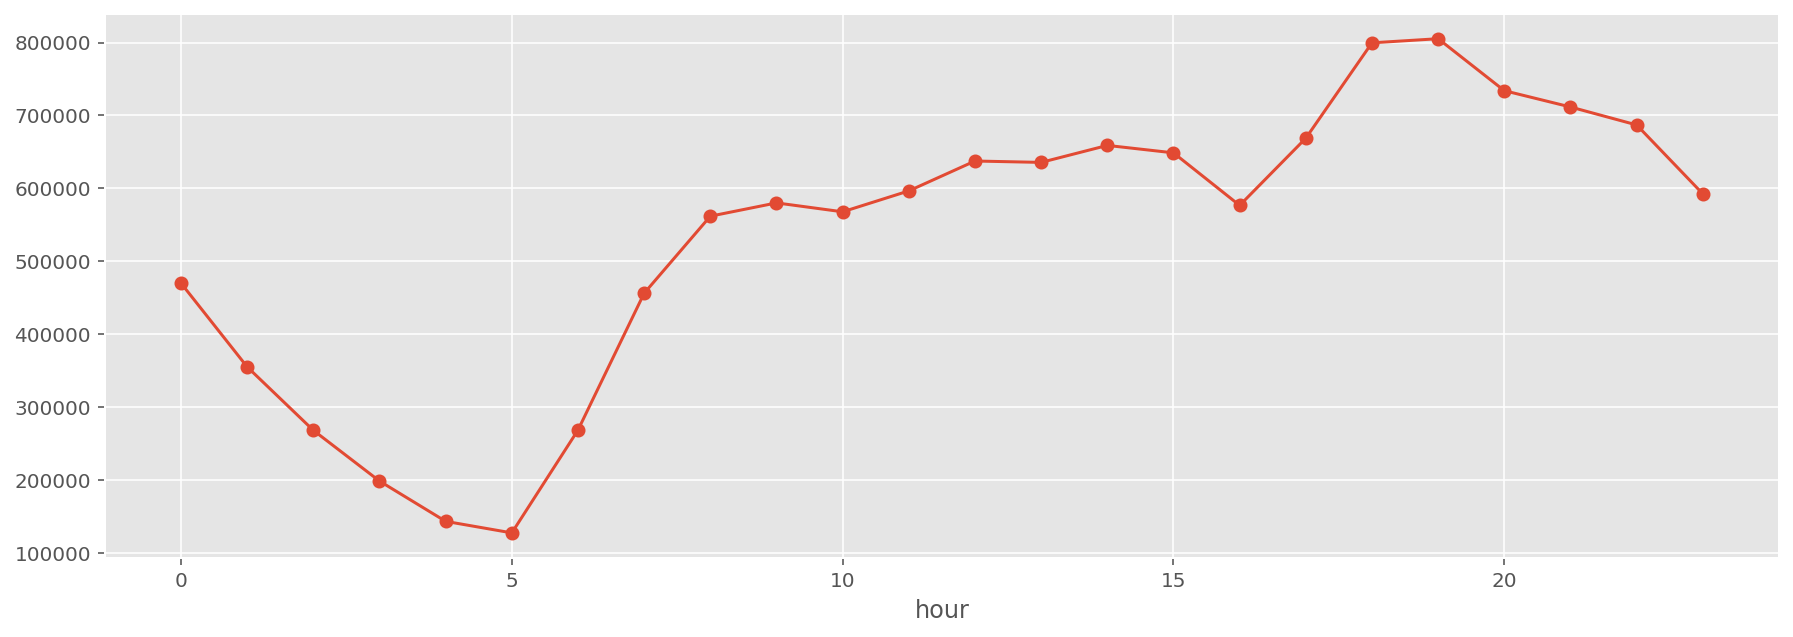

In [19]:
df.groupby('hour')['cnt'].sum().plot(x='hour', y='cnt', kind='line', style='-o', figsize=(15, 5));

- 요일별 Trip수
    - 월요일~토요일까지 이용이 계속 증가하고 일요일에 감소한다.

In [29]:
df.groupby('weekday')['cnt'].mean().iplot(kind='bar')

- 시간대별, 요일별 평균 Trip수
    - 주말(5, 6)과 평일(0~4)간의 패턴차이가 보인다.

In [20]:
df.groupby(['hour', 'weekday'])['cnt'].mean().unstack().iplot()

- 시간대별, 요일별 HeatMap
    - 대체적으로 18 ~ 19에 수요가 몰리고, 평일 7 ~ 9에 비해 주말은 수요가 적다.
    - 평일과 주말간 어느정도 수요의 차이가 보인다.

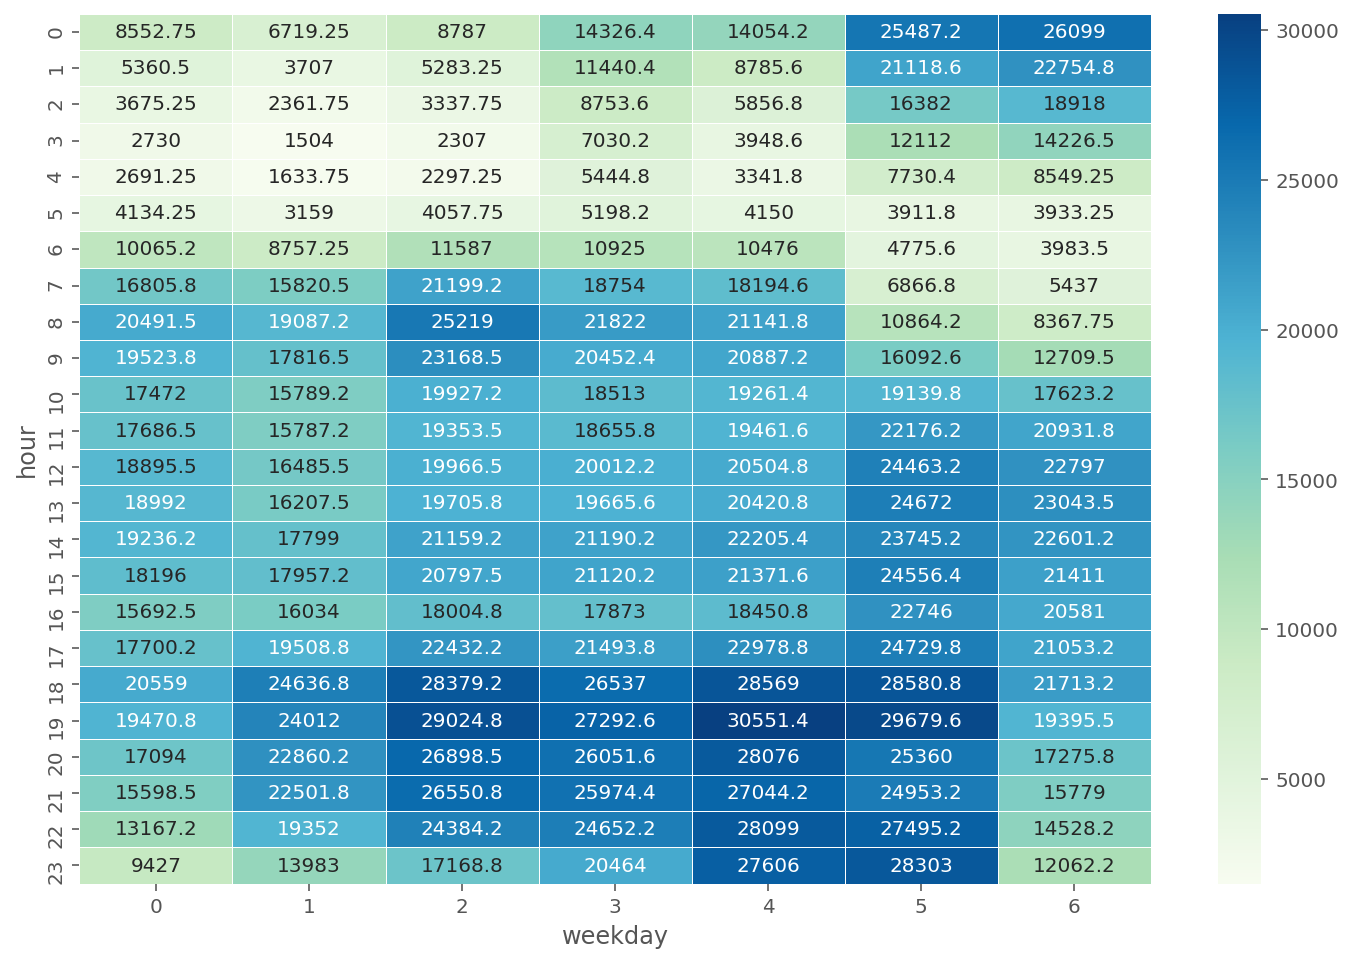

In [31]:
plt.figure(figsize=(12, 8))

sns.heatmap(df.groupby(['hour', 'weekday'])['cnt'].mean().unstack(),
           lw=.5, annot=True, cmap='GnBu', fmt='g', annot_kws={'size': 10});

#### 평일/주말별 Trip수
- 주말이 평일보다 새벽시간대의 수요가 더 많다.
- 평일은 아침에, 주말은 점심에 상대적으로 수요가 더 많다는 것을 알 수 있다.

In [28]:
df['is_weekend'] = (df.index.weekday // 5 == 1).astype(int)

df.groupby(['hour', 'is_weekend'])['cnt'].mean().unstack().iplot()

#### 요일별 시간대별 Violinplot
- 위의 lineplot과 heatmap과 동일하게 평일과 주말간의 흐름의 차이가 보이지만, 각 요일별 분포의 분산이 큰 특정 시간대가 존재한다.

In [ ]:
weekday_dict = {
    0:"Monday",
    1:"Tuesday",
    2:"Wednesday",
    3:"Thursday",
    4:"Friday",
    5:"Saturday",
    6:"Sunday"
}

def visualize_violinplot_by_weekday(df, y, weekday):
    plt.figure(figsize=(16, 3));
    sns.violinplot(x="hour", y=y, hue="weekday", 
                   data=df[df['weekday'] == weekday][['hour', 'weekday', y]],
                   inner="quart");    
    plt.title(f"{weekday_dict[weekday]}'s hourly violinplot {y}(2015-01 Data)")

In [ ]:
for weekday in range(0, 7):
    visualize_violinplot_by_weekday(df, 'cnt', weekday)

#### 주차별 시간대별 Trip 수
- 주차별, 시간대별 수요의 흐름은 비슷한 것으로 보여진다.

In [32]:
def visualization_hourly_boxplot_by_weeknum(df, y, weeknum):
    plt.figure(figsize=(15, 5))
    sns.boxplot(x='hour', y=y, data=df[df['weeknum'] == weeknum])
    plt.title(f"Hourly Boxplot (2015-01 {weeknum:02} Data)")
    
    plt.show()

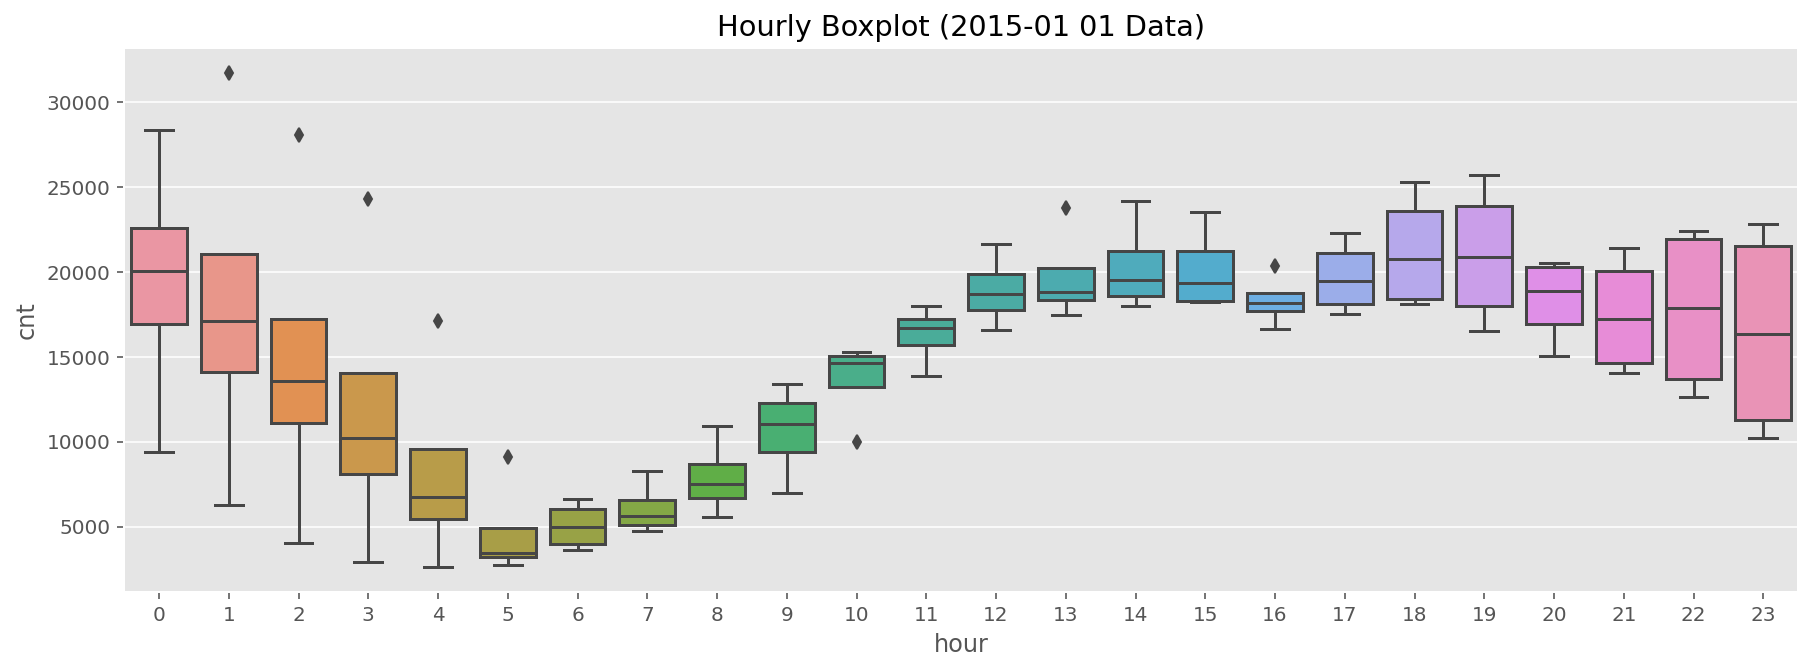

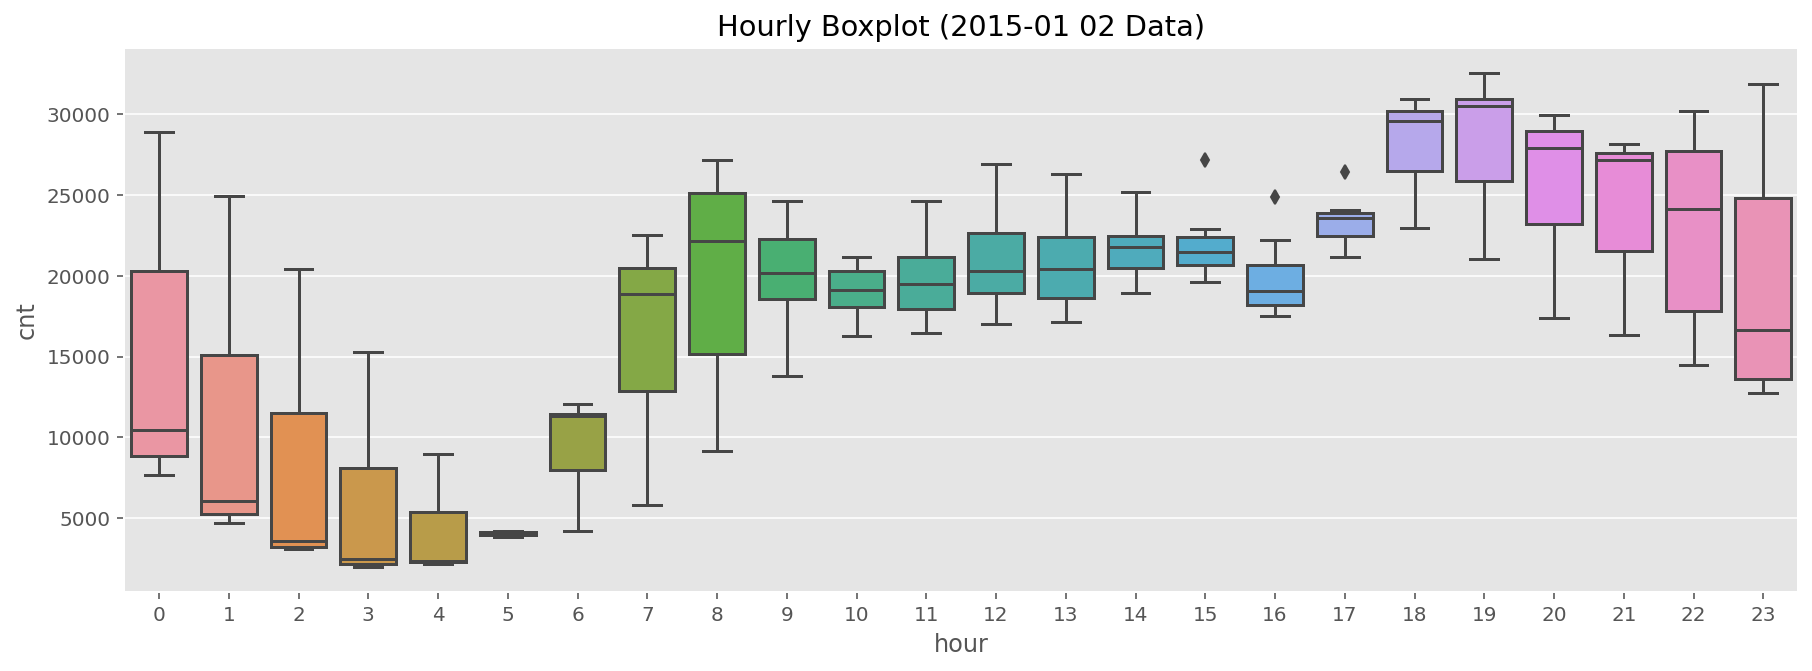

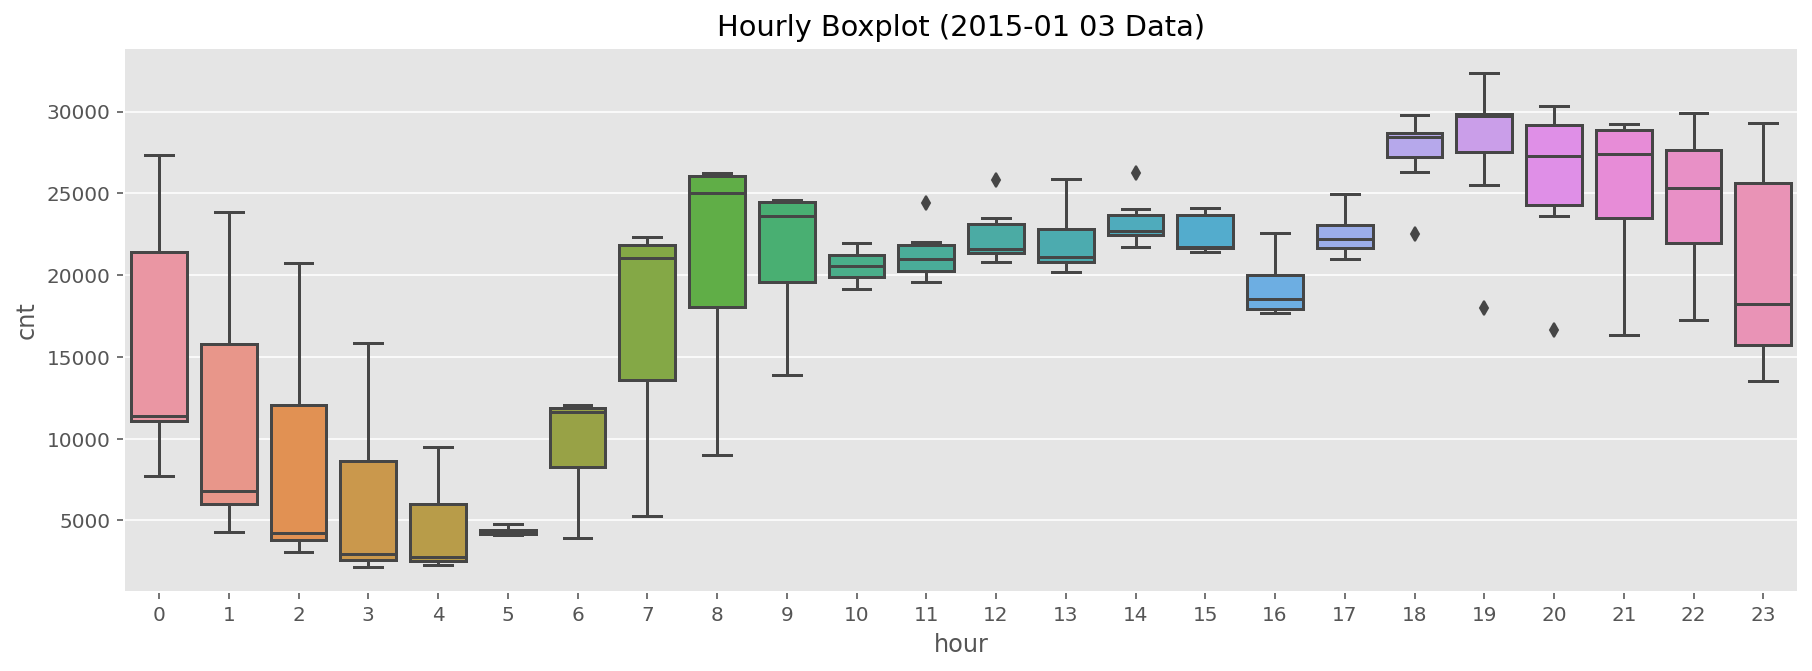

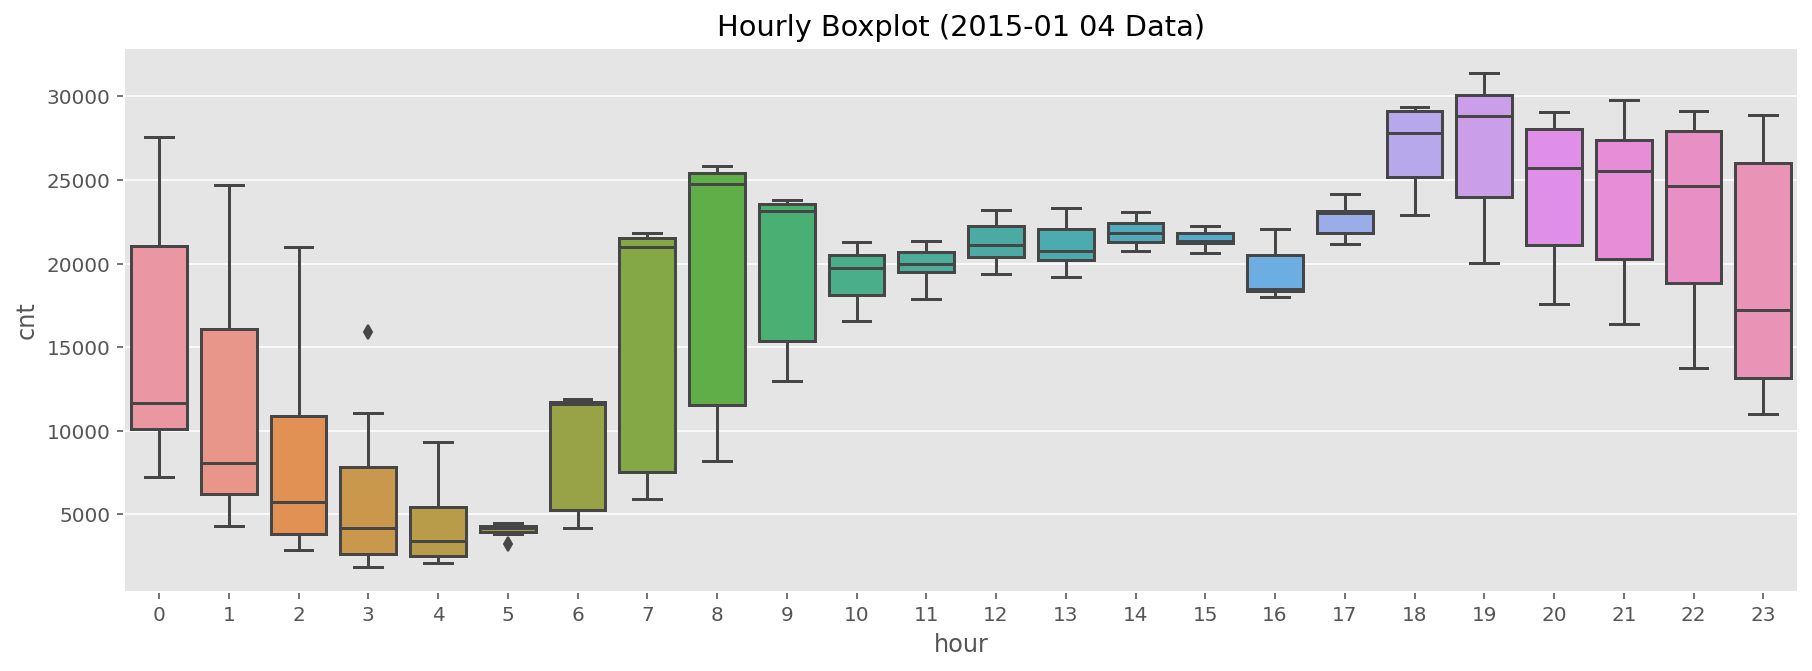

In [33]:
for week in range(1, 5):
    visualization_hourly_boxplot_by_weeknum(df, 'cnt', week)

---

---

## NYC 뉴욕 택시 데이터 EDA (Distance)

### Trip_distance별 Trip의 수요

In [39]:
# 30 단위로 bucketting >> 0~29 : 0, 30~59 : 30, 60~89 : 60...
# 2015.01 데이터 중 bucketting한 거리에 대한 그룹핑 후, 거리와 trip 수를 출력
trip_distance_query = """
SELECT 
    floor(trip_distance/30)*30 as bucket_floor,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY bucket_floor
order by bucket_floor
"""

# 2015.01 데이터 중 bucketting한 거리에 대한 그룹핑 후, 거리와 log scaling trip 수를 출력
trip_distance_query_log = """
SELECT 
    floor(trip_distance/30)*30 as bucket_floor,
    log10(count(*)) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY bucket_floor
order by bucket_floor
"""

distance_df = pd.read_gbq(query=trip_distance_query, dialect='standard', project_id=info['project'])
distance_log_df = pd.read_gbq(query=trip_distance_query_log, dialect='standard', project_id=info['project'])

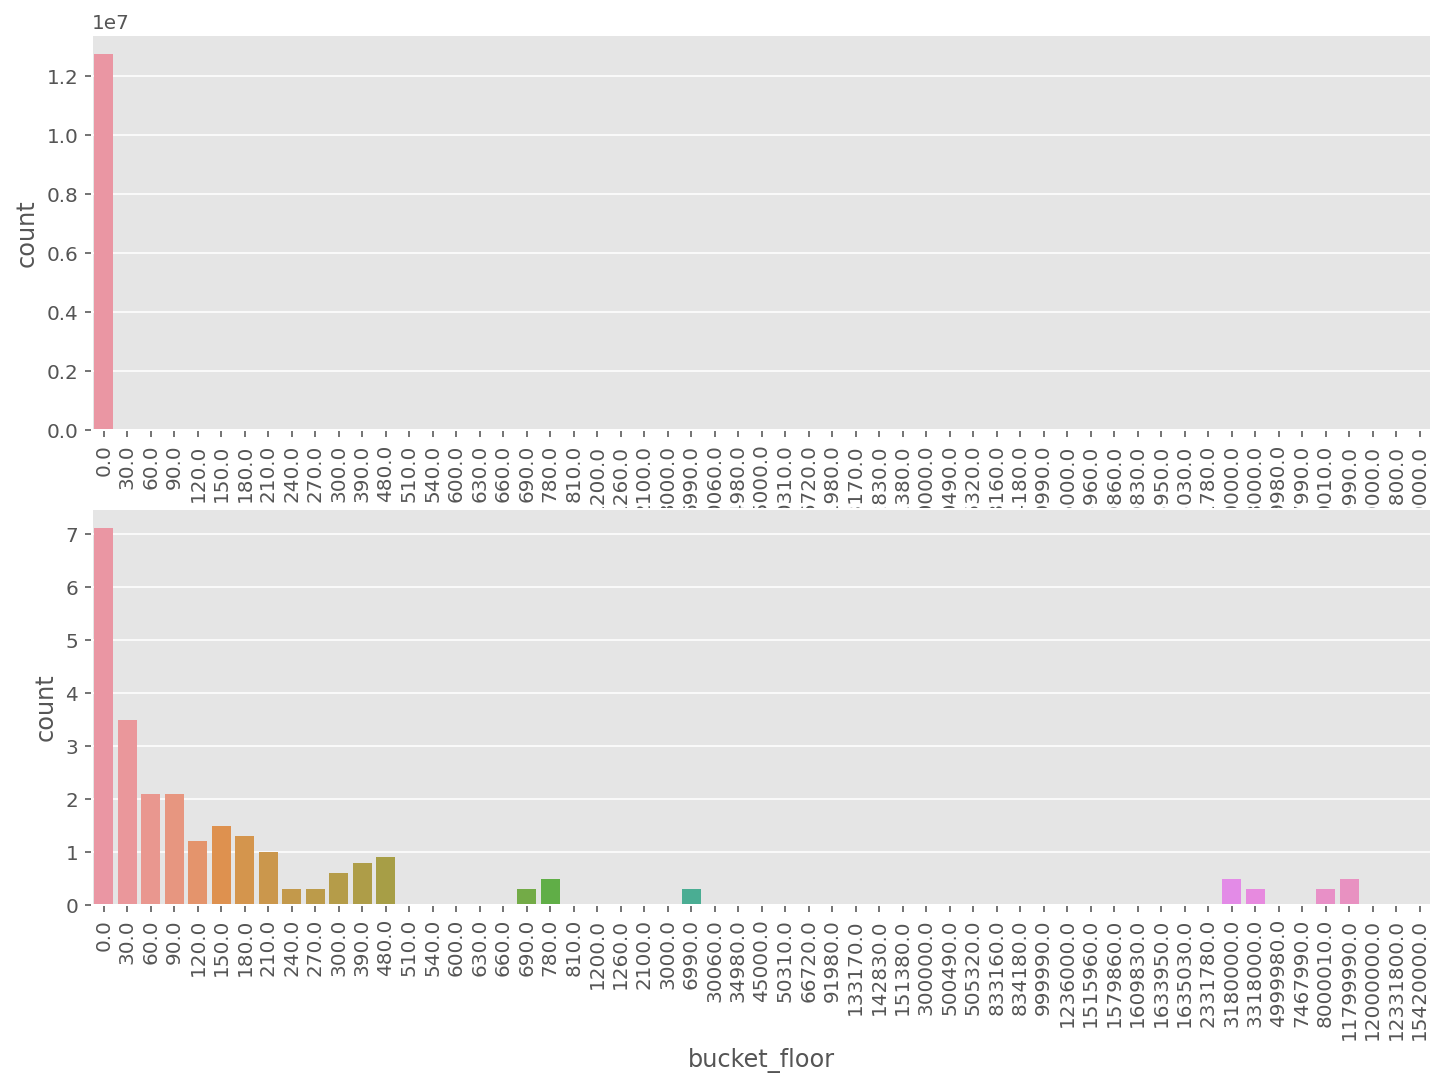

In [42]:
# 짧은 거리의 이용 수가 많기에 나머지들은 그래프에 보이지 않음 >> log를 씌워 값을 축소시킨 뒤 시각화
plt.figure(figsize=(12, 8))

plt.subplot(211)
sns.barplot(x=distance_df['bucket_floor'], y=distance_df['count'])
plt.xticks(rotation=90)

plt.subplot(212)
sns.barplot(x=distance_log_df['bucket_floor'], y=distance_log_df['count'])
plt.xticks(rotation=90)

plt.show()

### 장거리/단거리 수요
- 시간대별 장거리/단거리 수요
    - trip_distance < 30 : 단거리
    - trip_distance >= 30 : 장거리

In [43]:
# trip_distance가 30 미만인 데이터 중 시간만 추출한 pickup_hour, dropoff_hour로 그룹핑한 데이터의 시간과 그룹간 총 수를 출력
short_trip_query = """
SELECT 
    EXTRACT(HOUR FROM pickup_datetime) as pickup_hour,
    EXTRACT(HOUR FROM dropoff_datetime) as dropoff_hour,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE (EXTRACT(MONTH from pickup_datetime) = 1) and (trip_distance < 30)
GROUP BY pickup_hour, dropoff_hour
"""

# trip_distance가 30 이상인 데이터 중 시간만 추출한 pickup_hour, dropoff_hour로 그룹핑한 데이터의 시간과 그룹간 총 수를 출력
long_trip_query = """
SELECT 
    EXTRACT(HOUR FROM pickup_datetime) as pickup_hour,
    EXTRACT(HOUR FROM dropoff_datetime) as dropoff_hour,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE (EXTRACT(MONTH from pickup_datetime) = 1) and (trip_distance >= 30)
GROUP BY pickup_hour, dropoff_hour

"""

short_trip_df = pd.read_gbq(query=short_trip_query, dialect='standard', project_id=info['project'])
long_trip_df = pd.read_gbq(query=long_trip_query, dialect='standard', project_id=info['project'])

In [53]:
# index 1 : short의 경우 14시에 타서 14시에 내린 수가 511868, long의 경우 6시에 타서 8시에 내린 수가 13이다.
pd.concat([short_trip_df, pd.DataFrame(long_trip_df.values, columns='long_'+long_trip_df.columns)], axis=1).head()

,pickup_hour,dropoff_hour,count,long_pickup_hour,long_dropoff_hour,long_count
0,19,19,653731,14.0,15.0,137.0
1,14,14,511868,6.0,8.0,13.0
2,21,21,575352,5.0,6.0,53.0
3,9,9,457809,19.0,20.0,104.0
4,5,6,27610,16.0,16.0,27.0


In [55]:
# 두 df를 pickup_hour, dropoff_hour 기준으로 merge
trip_df = short_trip_df.merge(long_trip_df, on=["pickup_hour", "dropoff_hour"], suffixes=["_short", "_long"])
trip_df.head(2)

,pickup_hour,dropoff_hour,count_short,count_long
0,19,19,653731,30
1,14,14,511868,28


In [58]:
trip_df_pickup = trip_df.groupby(["pickup_hour"], as_index=False).agg({'count_short':'sum', 'count_long':'sum'}) \
                                                                      .sort_values(by="pickup_hour")
trip_df_dropoff = trip_df.groupby(["dropoff_hour"], as_index=False).agg({'count_short':'sum', 'count_long':'sum'}) \
                                                                      .sort_values(by="dropoff_hour")

In [61]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # 24시간을 위한 theta 생성
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # plot의 각각의 bin width 지정
    width = 2*np.pi / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # label을 시계 방향으로 설정하고 위에서 시작
    ax.set_theta_zero_location("N")
    # 시계 방향 설정
    ax.set_theta_direction(-1)

    # label 설정
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)
    
    
def diff_short_long_trip_on_time(trip_df_pickup, trip_df_dropoff):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    # 2, 2의 첫번째에 그림
    ax = plt.subplot(2,2,1, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_pickup['count_short'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    # 2, 2의 두번째에 그림
    ax = plt.subplot(2,2,2, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_pickup['count_long'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    ax = plt.subplot(2,2,3, polar=True)
    radii = np.array(trip_df_dropoff['count_short'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,4, polar=True)
    radii = np.array(trip_df_dropoff['count_long'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

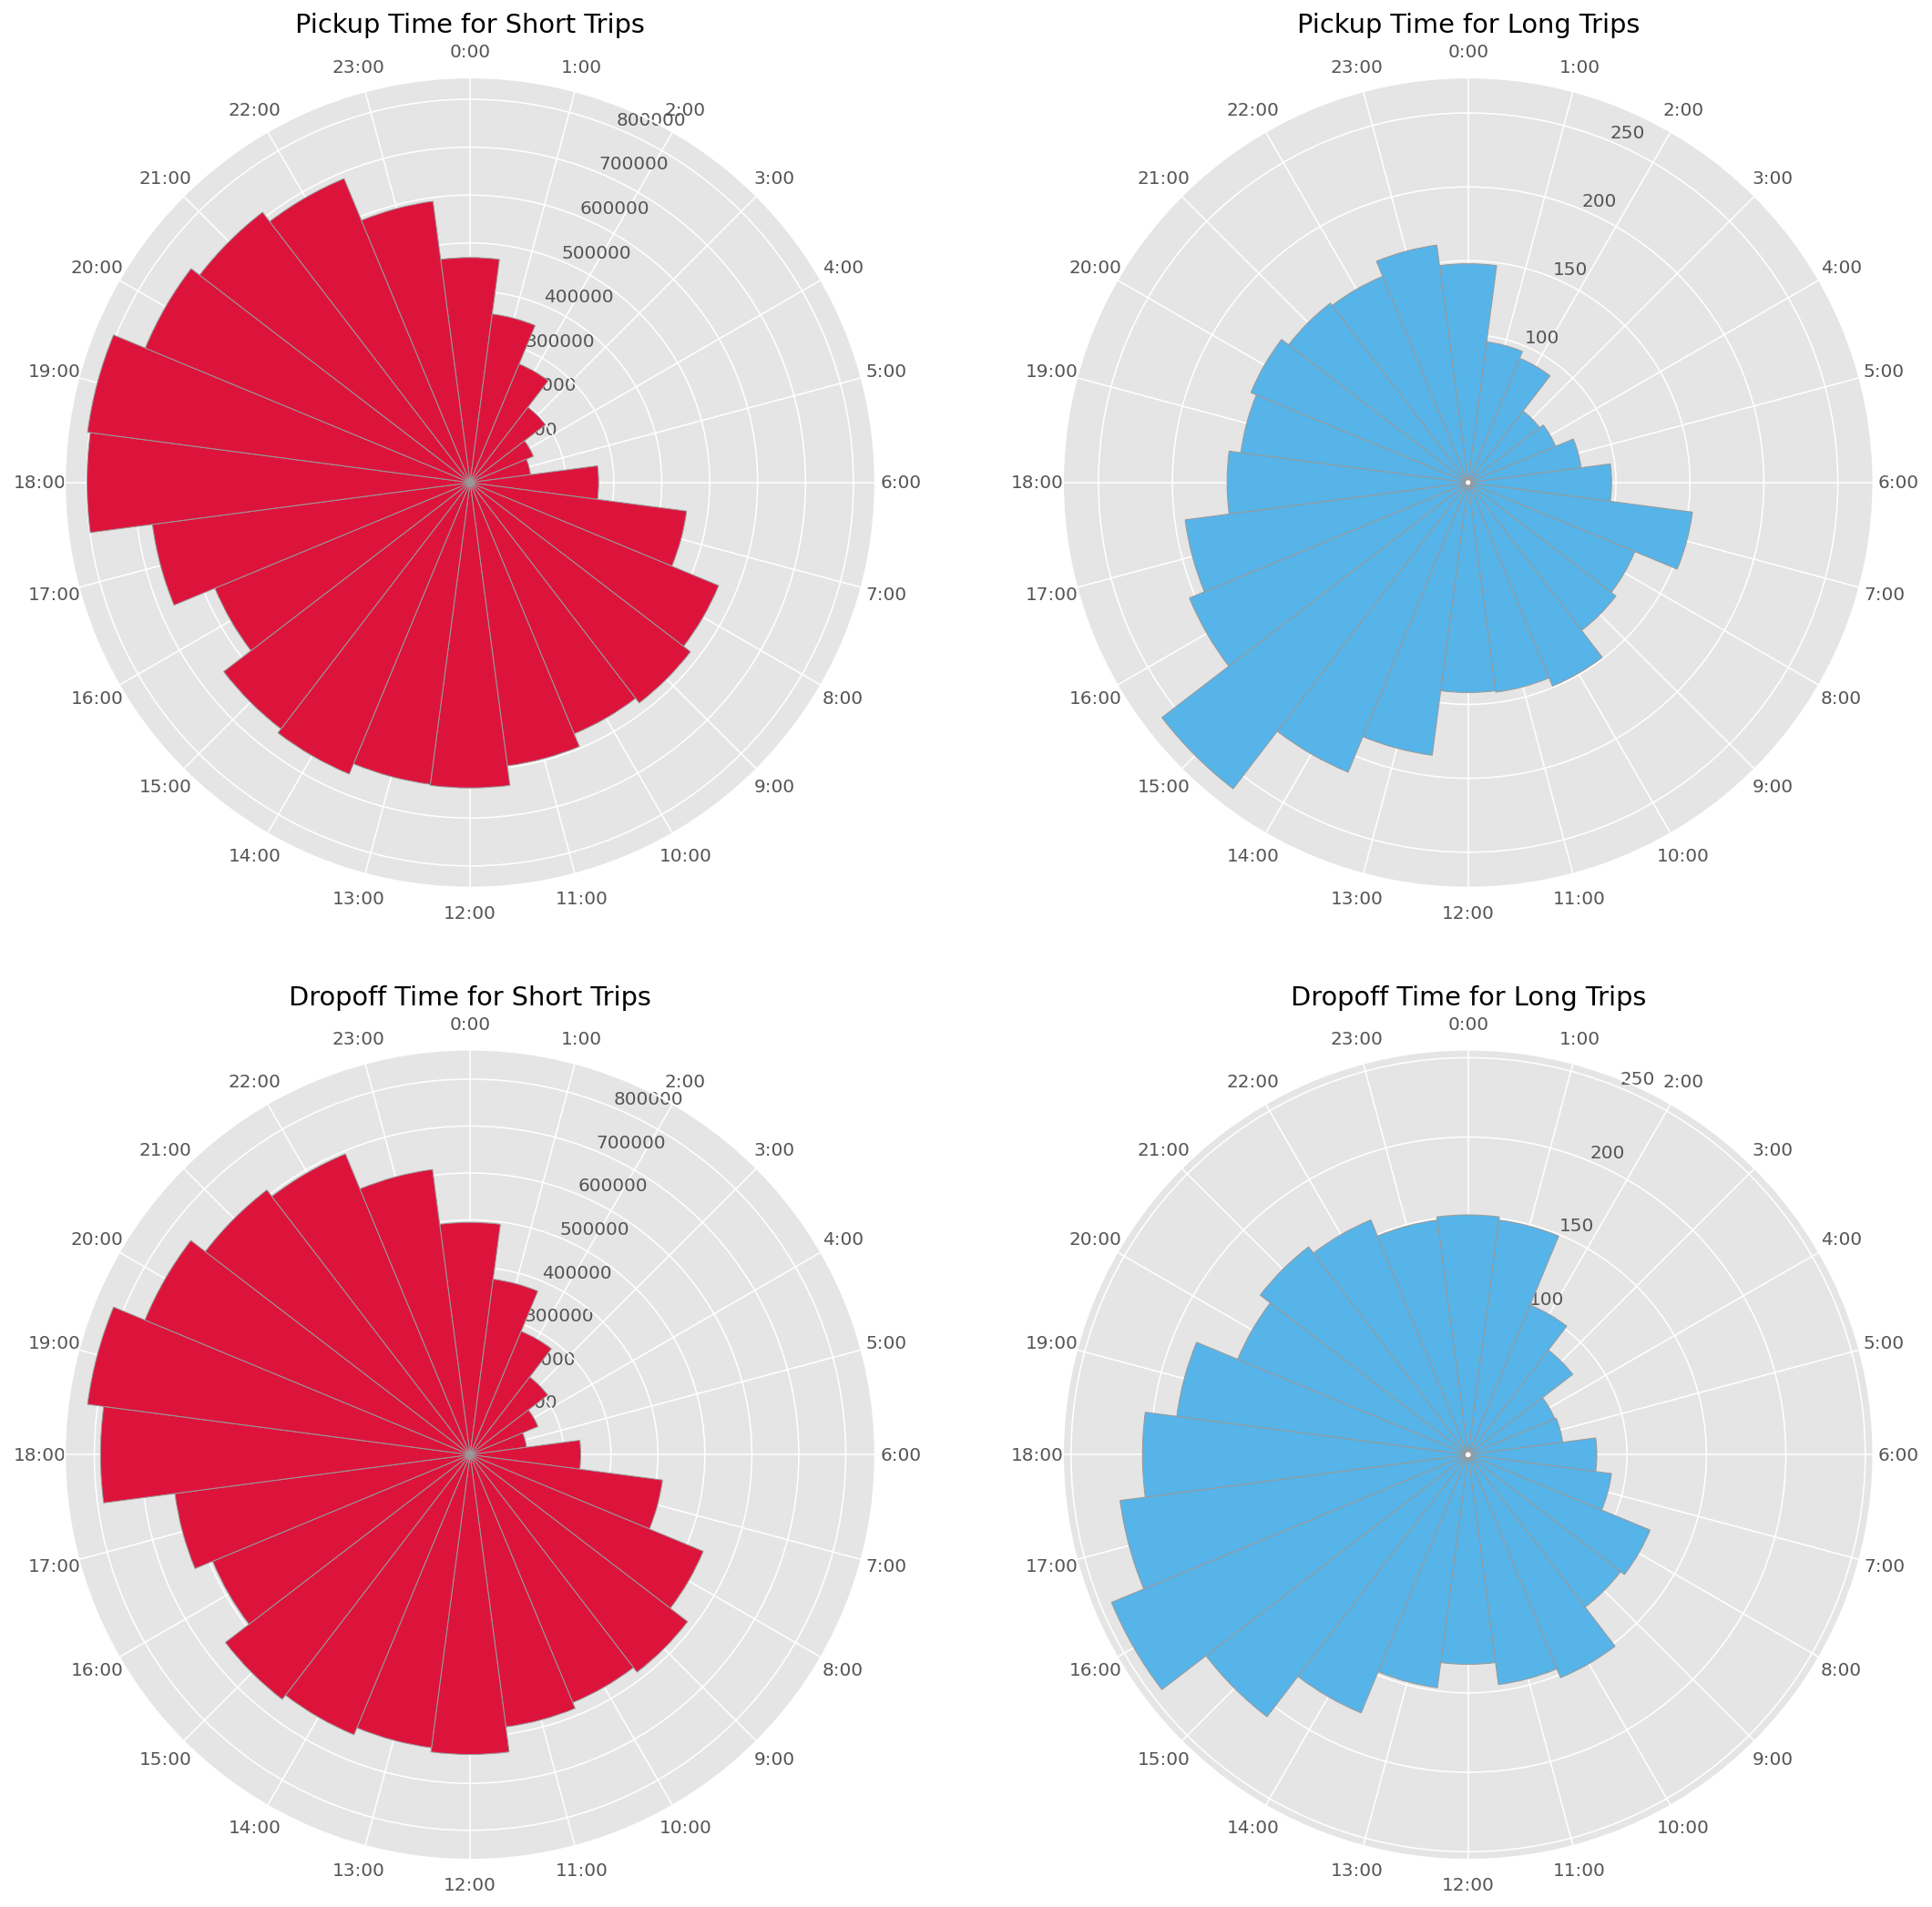

In [62]:
diff_short_long_trip_on_time(trip_df_pickup, trip_df_dropoff)

- 피크 타임
    - Short trip
        - 18:00 ~ 22:00
    - Long trip
        - 13:00 ~ 15:30

---

---

## NYC 뉴욕 택시 데이터 EDA (Region)

In [2]:
# 1월의 데이터만 추출한 임시 테이블 base_data

# base_data에서 위도 [-90, 90]이고 zip_codes에서 code가 NY인 CROSS JOIN 데이터 중
# zip_code_geom이 st_geogpoint(pickup_longitude, pickup_latitude)를 포함하는 행을 리턴하는 temp 임시테이블 생성 후
# temp에서 zip_code에 따른 Trip에 대한 수요 데이터 추출
query = """
WITH base_data AS 
(
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE EXTRACT(MONTH from pickup_datetime) = 1
) 
, temp AS (
    SELECT nyc_taxi.*, gis.* 
    FROM (
        SELECT *
        FROM base_data
        WHERE pickup_latitude  <= 90 and pickup_latitude >= -90
        ) as nyc_taxi
    JOIN (
        SELECT zip_code, state_code, state_name, city, county, zip_code_geom
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE state_code='NY'
        ) as gis 
    ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code, 
    city,
    ST_ASTEXT(zip_code_geom) as zip_code_geom,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id=info['project'], auth_local_webserver=True)

In [3]:
df.tail(2)

,zip_code,city,zip_code_geom,pickup_hour,cnt
87018,11210,New York city,"POLYGON((-73.9584 40.636327, -73.958198 40.635...",2015-01-31 23:00:00,1
87019,10075,New York city,"POLYGON((-73.964687 40.775677, -73.965148 40.7...",2015-01-31 23:00:00,326


#### Trip에 대한 수요가 많은 zip_code TOP5

In [7]:
zip_code_agg_df = df.groupby(['zip_code', 'zip_code_geom'])[['cnt']].sum().reset_index()
zip_code_agg_df['percent'] = (zip_code_agg_df[['cnt']]/df[['cnt']].sum()).round(3).rename(columns={'cnt':'percent'}).reset_index()['percent'] * 100 
zip_code_agg_df.head(5)

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,5.1
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,1.9
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,5.7
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.5
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.4


In [75]:
# cnt가 적은 데이터 제외 (percent == 0)
filter_agg_df = zip_code_agg_df[zip_code_agg_df['percent'] > 0]
print(f"{zip_code_agg_df['cnt'].sum()} >> {filter_agg_df['cnt'].sum()}")

12322300 >> 12197865


#### zip_code별, date별 수요의 합계에 대한 Boxplot

In [77]:
filter_zip_code = filter_agg_df['zip_code'].to_list()

zip_df = df[['zip_code', 'zip_code_geom', 'pickup_hour', 'cnt']]
zip_df['date'] = zip_df['pickup_hour'].dt.date

filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code)]

filter_zip_daily_df = filter_zip_df.groupby(['zip_code','date'])[['cnt']].sum().reset_index()

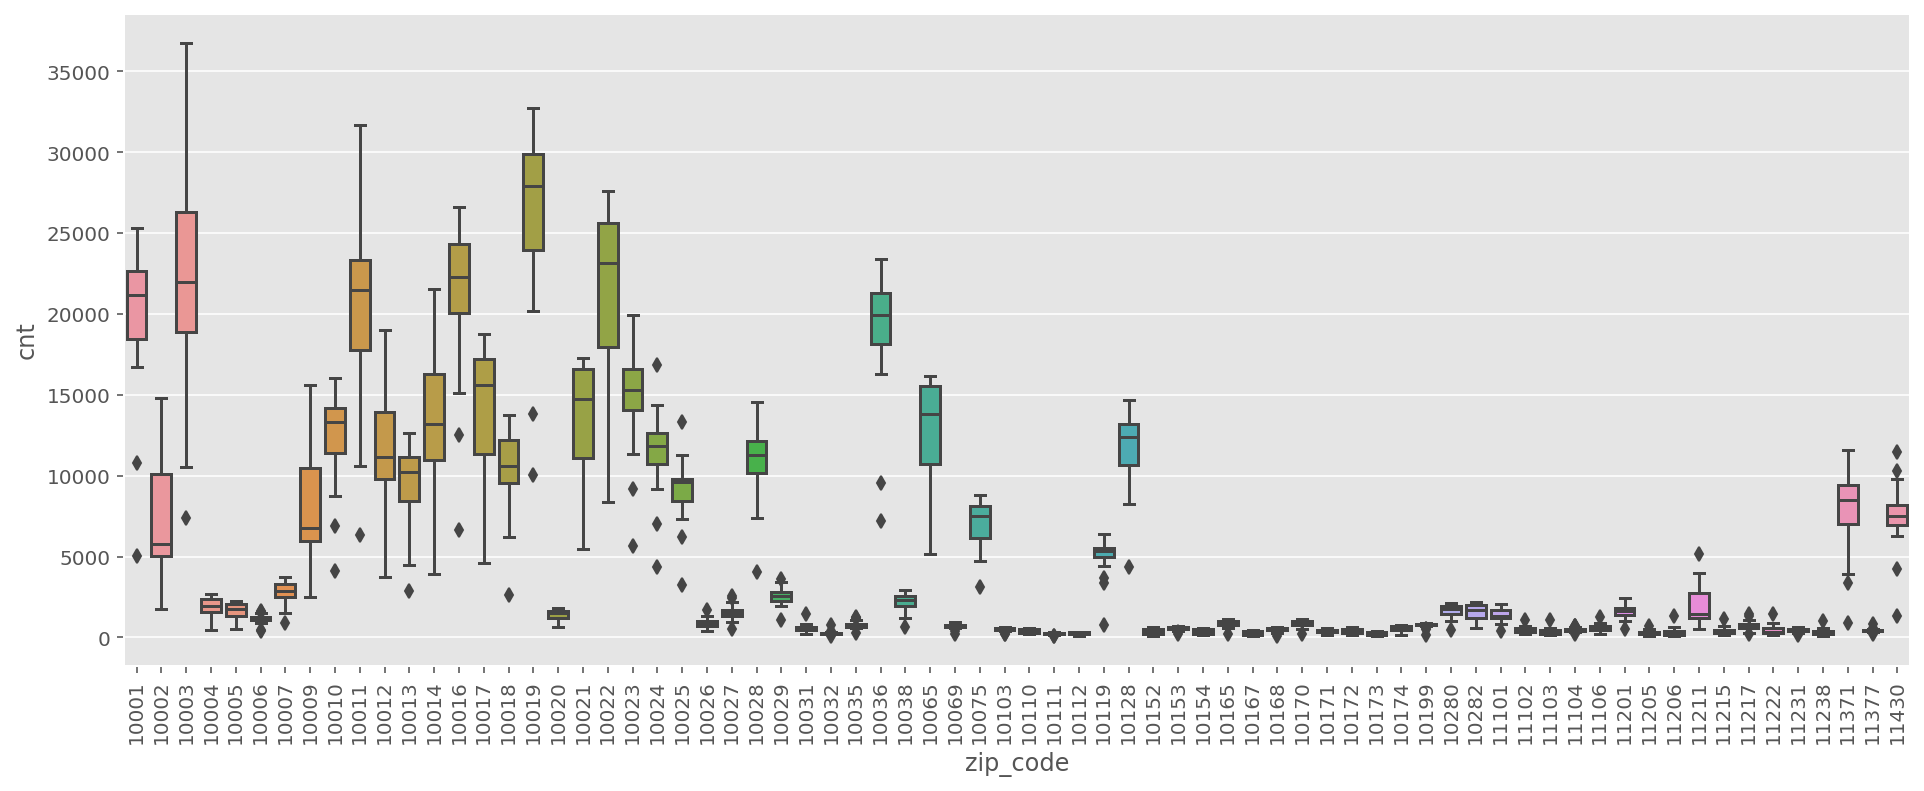

In [80]:
plt.figure(figsize=(16, 6))

sns.boxplot(x='zip_code', y='cnt', data=filter_zip_daily_df)
plt.xticks(rotation=90)

plt.show()

---

---

## EDA Result

### Time

### Distance

### Region